<a href="https://colab.research.google.com/github/Saxenaharsh12/PII_Detection_Correction_System-/blob/main/suspicious.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fusion model not found. Using available methods.
CNN model not found. Using only traditional forensics methods.
To train the fusion model, you need to provide training data with examples of authentic and tampered PAN cards.
Fusion model not found at pan_card_tampering/models/pan_tampering_fusion_detector.h5. Please train the model first.


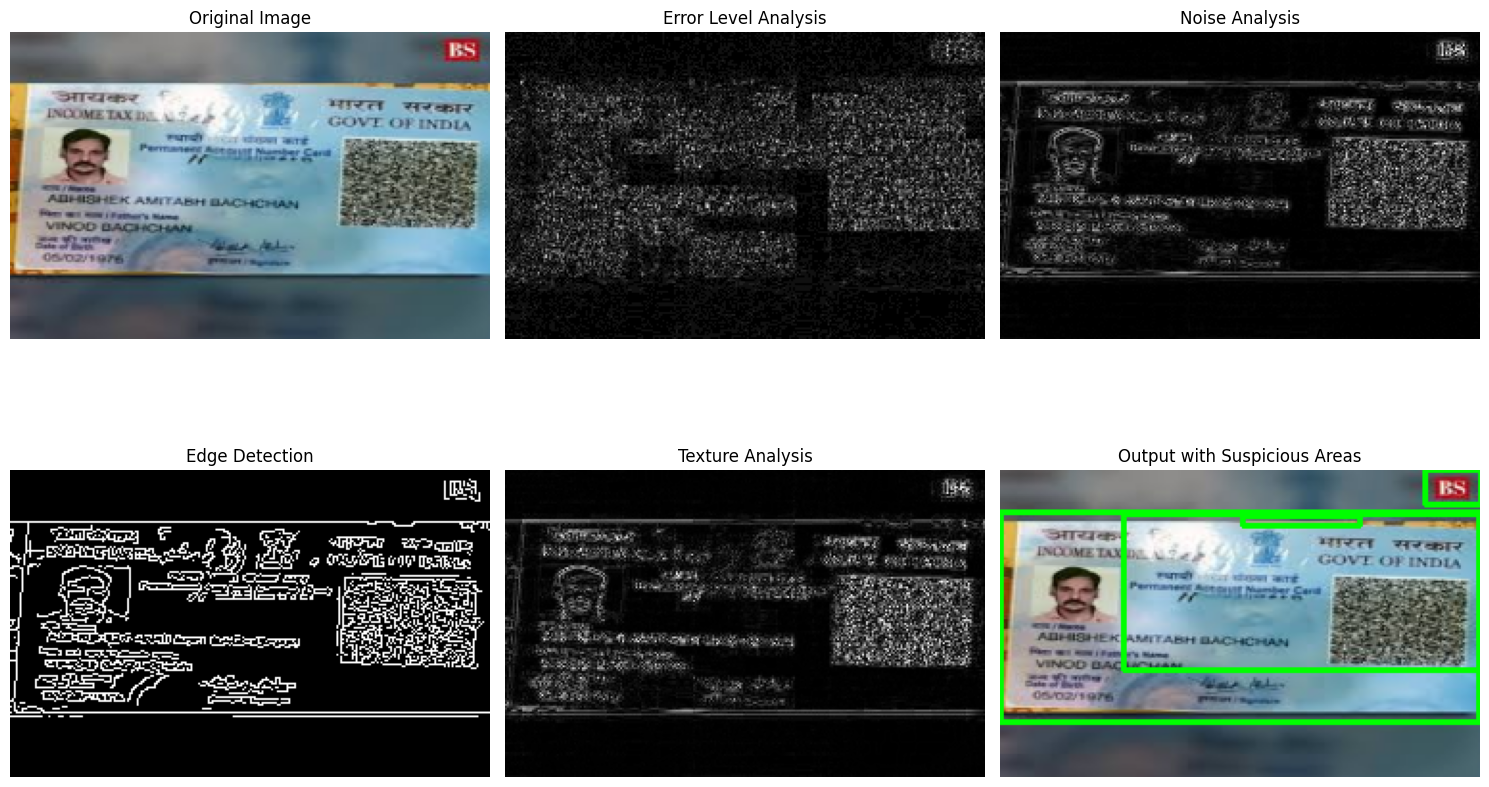

DETECTION RESULT: TAMPERED
Confidence: 100.00%
Detection Method: traditional_only
Traditional Score: 353.46%

Suspicious areas highlighted in green on the output image.
Number of suspicious regions: 4

Note: For best results with fewer false positives, train the fusion model with your dataset.


In [3]:
# Import necessary packages
import cv2
import numpy as np
import imutils
from PIL import Image
import requests
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Colab-compatible image display
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Create directories if they don't exist
os.makedirs('pan_card_tampering/image', exist_ok=True)
os.makedirs('pan_card_tampering/models', exist_ok=True)

# Constants for the CNN model
IMG_HEIGHT = 160
IMG_WIDTH = 250
CHANNELS = 3
MODEL_PATH = 'pan_card_tampering/models/pan_tampering_detector.h5'
FUSION_MODEL_PATH = 'pan_card_tampering/models/pan_tampering_fusion_detector.h5'

# ==================== Handcrafted Feature Extraction ====================

def extract_forensic_features(image):
    """
    Extract handcrafted forensic features from an image
    Returns feature vector and visualization images
    """
    # Make sure image is properly loaded
    if isinstance(image, str):
        if image.startswith('http'):
            img = Image.open(requests.get(image, stream=True).raw)
            img.save('pan_card_tampering/image/temp.png')
            image = cv2.imread('pan_card_tampering/image/temp.png')
        else:
            image = cv2.imread(image)

    # Resize for consistency
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a copy for visualization
    output = image.copy()

    # --------- Feature 1: Error Level Analysis (ELA) ---------
    # Save the image at a known quality
    cv2.imwrite('pan_card_tampering/image/temp_ela.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 90])

    # Load the saved image
    saved_img = cv2.imread('pan_card_tampering/image/temp_ela.jpg')
    saved_gray = cv2.cvtColor(saved_img, cv2.COLOR_BGR2GRAY)

    # Calculate the difference between the original and the saved image
    ela_diff = cv2.absdiff(gray, saved_gray)

    # Amplify the difference for better visualization
    ela_diff = cv2.convertScaleAbs(ela_diff, alpha=10, beta=0)

    # Apply threshold to highlight significant differences
    _, ela_thresh = cv2.threshold(ela_diff, 25, 255, cv2.THRESH_BINARY)

    # --------- Feature 2: Noise Analysis ---------
    # Apply a blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Calculate noise mask (difference between original and blurred)
    noise = cv2.absdiff(gray, blurred)

    # Threshold to highlight high-noise areas
    _, noise_thresh = cv2.threshold(noise, 15, 255, cv2.THRESH_BINARY)

    # --------- Feature 3: Edge Inconsistency Detection ---------
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150)

    # --------- Feature 4: Texture Analysis ---------
    # Calculate GLCM texture features (simplified with variance as a proxy)
    texture = cv2.Laplacian(gray, cv2.CV_64F)
    texture = np.uint8(np.absolute(texture))

    # --------- Feature 5: Frequency Domain Analysis ---------
    # Perform DFT
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Combine detection results (binary masks)
    combined_detection = cv2.bitwise_or(ela_thresh, noise_thresh)

    # Find contours in the combined detection
    combined_contours = cv2.findContours(combined_detection.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    combined_contours = imutils.grab_contours(combined_contours)

    # Filter by size and draw on output image
    suspicious_area = 0
    suspicious_regions = []
    for c in combined_contours:
        # Get bounding rectangle
        (x, y, w, h) = cv2.boundingRect(c)

        # Filter by size (adjust thresholds based on your specific use case)
        area = cv2.contourArea(c)
        if area > 25:  # Minimum area threshold
            suspicious_area += area
            suspicious_regions.append((x, y, w, h))
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Calculate a suspicion score based on suspicious area percentage
    total_area = IMG_WIDTH * IMG_HEIGHT
    suspicion_score = suspicious_area / total_area

    # Extract statistical features from each analysis
    def extract_stats(img):
        """Extract statistical features from an image"""
        img_flat = img.flatten().astype(np.float32)
        return [
            np.mean(img_flat),
            np.std(img_flat),
            np.percentile(img_flat, 75),
            np.percentile(img_flat, 90),
            np.max(img_flat)
        ]

    # Compile feature vector from different analyses
    features = []
    features.extend(extract_stats(ela_diff))      # 5 features
    features.extend(extract_stats(noise))         # 5 features
    features.extend(extract_stats(edges))         # 5 features
    features.extend(extract_stats(texture))       # 5 features
    features.extend(extract_stats(magnitude_spectrum))  # 5 features

    # Add suspicion score itself as a feature
    features.append(suspicion_score)

    # Add counts of suspicious regions
    features.append(len(suspicious_regions))

    # Add metadata features about the image
    features.append(np.mean(gray) / 255.0)  # Mean brightness
    features.append(np.std(gray) / 255.0)   # Contrast

    # Create and normalize the feature vector
    feature_vector = np.array(features, dtype=np.float32)

    # Calculate normalization with a reasonable scale
    feature_vector = feature_vector / np.max([feature_vector.max(), 1.0])

    return {
        'features': feature_vector,
        'original': image,
        'ela': ela_diff,
        'noise': noise,
        'edges': edges,
        'texture': texture,
        'frequency': magnitude_spectrum,
        'output': output,
        'combined_detection': combined_detection,
        'suspicion_score': suspicion_score,
        'suspicious_regions': suspicious_regions
    }

# ==================== CNN Model Functions ====================

def create_fusion_model():
    """Create a fusion model combining CNN features with handcrafted forensic features"""
    # Input for handcrafted features
    # We have 28 handcrafted features in total
    forensic_input = Input(shape=(28,), name='forensic_features')

    # CNN branch using EfficientNetB0
    image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='image_input')
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=image_input
    )

    # Freeze early layers of the CNN
    for layer in base_model.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False

    # CNN branch processing
    x_cnn = base_model.output
    x_cnn = GlobalAveragePooling2D()(x_cnn)
    x_cnn = Dense(256, activation='relu')(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = Dropout(0.5)(x_cnn)

    # Handcrafted feature branch processing
    x_forensic = Dense(64, activation='relu')(forensic_input)
    x_forensic = BatchNormalization()(x_forensic)
    x_forensic = Dropout(0.3)(x_forensic)

    # Concatenate both branches
    merged = concatenate([x_cnn, x_forensic])

    # Joint processing
    x = Dense(128, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Create model with two inputs
    model = Model(inputs=[image_input, forensic_input], outputs=output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def preprocess_for_fusion_model(image):
    """Preprocess an image and extract features for the fusion model"""
    # Extract handcrafted features
    forensic_results = extract_forensic_features(image)

    # Preprocess image for CNN
    if isinstance(image, str):
        if image.startswith('http'):
            img = Image.open(requests.get(image, stream=True).raw)
            img.save('pan_card_tampering/image/temp.png')
            img_arr = cv2.imread('pan_card_tampering/image/temp.png')
        else:
            img_arr = cv2.imread(image)
    elif isinstance(image, np.ndarray):
        img_arr = image.copy()
    else:
        raise ValueError("Image must be a path or numpy array")

    img_arr = cv2.resize(img_arr, (IMG_WIDTH, IMG_HEIGHT))
    img_arr = img_arr.astype(np.float32) / 255.0  # Normalize to 0-1
    img_arr = np.expand_dims(img_arr, axis=0)  # Add batch dimension

    # Reshape handcrafted features for model input
    features = np.expand_dims(forensic_results['features'], axis=0)

    return {
        'image_input': img_arr,
        'forensic_features': features,
        'visualization': forensic_results
    }

def train_fusion_model(authentic_image_paths, tampered_image_paths):
    """Train the fusion model on authentic and tampered images"""
    # Create model
    model = create_fusion_model()

    # Print model summary
    model.summary()

    # Prepare data
    X_img = []
    X_features = []
    y = []

    print("Processing authentic images...")
    for path in authentic_image_paths:
        # Extract features
        results = preprocess_for_fusion_model(path)

        X_img.append(results['image_input'][0])  # Remove batch dimension
        X_features.append(results['forensic_features'][0])  # Remove batch dimension
        y.append(0)  # 0 = authentic

    print("Processing tampered images...")
    for path in tampered_image_paths:
        # Extract features
        results = preprocess_for_fusion_model(path)

        X_img.append(results['image_input'][0])  # Remove batch dimension
        X_features.append(results['forensic_features'][0])  # Remove batch dimension
        y.append(1)  # 1 = tampered

    X_img = np.array(X_img)
    X_features = np.array(X_features)
    y = np.array(y)

    # Split data
    indices = np.arange(len(y))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)

    X_img_train, X_img_val = X_img[train_idx], X_img[val_idx]
    X_features_train, X_features_val = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Data augmentation for images only (not for features)
    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        brightness_range=[0.9, 1.1]
    )

    # Custom generator for both inputs
    def custom_generator(X_img, X_features, y, batch_size=32):
        img_gen = datagen.flow(X_img, y, batch_size=batch_size, seed=42)
        while True:
            # Get augmented image batch
            img_batch, y_batch = next(img_gen)
            # Get the same indices for features
            indices = img_gen.index_array
            # Create feature batch
            feature_batch = X_features[indices]
            # Yield both inputs and outputs
            yield {'image_input': img_batch, 'forensic_features': feature_batch}, y_batch

    # Create generator
    train_gen = custom_generator(X_img_train, X_features_train, y_train)

    # Callbacks
    checkpoint = ModelCheckpoint(
        FUSION_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    print("Training fusion model...")
    history = model.fit(
        train_gen,
        steps_per_epoch=len(X_img_train) // 32,
        validation_data=({'image_input': X_img_val, 'forensic_features': X_features_val}, y_val),
        epochs=30,
        callbacks=[checkpoint, early_stopping]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Evaluate on validation set
    y_pred_prob = model.predict({'image_input': X_img_val, 'forensic_features': X_features_val})
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Authentic', 'Tampered'],
                yticklabels=['Authentic', 'Tampered'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate and print metrics
    print(classification_report(y_val, y_pred, target_names=['Authentic', 'Tampered']))

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return model

def load_fusion_model():
    """Load the trained fusion model"""
    if os.path.exists(FUSION_MODEL_PATH):
        return load_model(FUSION_MODEL_PATH)
    else:
        print(f"Fusion model not found at {FUSION_MODEL_PATH}. Please train the model first.")
        return None

# ==================== Detection Functions ====================

def detect_tampering(image_path, threshold=0.5):
    """
    Detect tampering using the fusion model or fallback to simpler methods

    Args:
        image_path: Path to the image to check
        threshold: Classification threshold (0.5 default)

    Returns:
        dict: Results dictionary with detection information
    """
    # Load the fusion model
    fusion_model = load_fusion_model()

    # Extract features and preprocess
    preprocessed = preprocess_for_fusion_model(image_path)

    # Get visualization results
    results = preprocessed['visualization']

    # If model doesn't exist yet, we'll rely only on traditional methods
    if fusion_model is None:
        # Try to load the regular CNN model
        cnn_model = load_model(MODEL_PATH) if os.path.exists(MODEL_PATH) else None

        if cnn_model is None:
            # No models available, use only handcrafted features
            is_tampered = results['suspicion_score'] > 0.05  # 5% suspicious area threshold
            confidence = results['suspicion_score'] * 10  # Scale to 0-1 range (approximately)

            return {
                **results,
                'is_tampered': is_tampered,
                'confidence': min(confidence, 1.0),
                'method': 'traditional_only'
            }
        else:
            # Use CNN model with handcrafted features score (weighted average)
            cnn_score = cnn_model.predict(preprocessed['image_input'])[0][0]

            # Combine predictions (weighted average)
            trad_weight = 0.4
            cnn_weight = 0.6
            combined_score = (trad_weight * results['suspicion_score'] * 10) + (cnn_weight * cnn_score)

            # Determine if tampered
            is_tampered = combined_score > threshold

            return {
                **results,
                'is_tampered': is_tampered,
                'confidence': combined_score,
                'cnn_score': cnn_score,
                'method': 'cnn_with_traditional'
            }

    # Use the fusion model
    fusion_score = fusion_model.predict({
        'image_input': preprocessed['image_input'],
        'forensic_features': preprocessed['forensic_features']
    })[0][0]

    # Determine if tampered
    is_tampered = fusion_score > threshold

    return {
        **results,
        'is_tampered': is_tampered,
        'confidence': fusion_score,
        'fusion_score': fusion_score,
        'method': 'fusion_model'
    }

# ==================== Display Functions ====================

def display_results(results):
    """Display tampering detection results"""
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title("Error Level Analysis")
    plt.imshow(results['ela'], cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title("Noise Analysis")
    plt.imshow(results['noise'], cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title("Edge Detection")
    plt.imshow(results['edges'], cmap='gray')
    plt.axis('off')

    if 'texture' in results:
        plt.subplot(2, 3, 5)
        plt.title("Texture Analysis")
        plt.imshow(results['texture'], cmap='gray')
        plt.axis('off')
    else:
        plt.subplot(2, 3, 5)
        plt.title("Combined Detection")
        plt.imshow(results['combined_detection'], cmap='gray')
        plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title("Output with Suspicious Areas")
    plt.imshow(cv2.cvtColor(results['output'], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection results
    tampered_text = "TAMPERED" if results['is_tampered'] else "AUTHENTIC"
    confidence = results['confidence'] * 100

    print(f"DETECTION RESULT: {tampered_text}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Detection Method: {results['method']}")

    if 'fusion_score' in results:
        print(f"Fusion Model Score: {results['fusion_score'] * 100:.2f}%")

    if 'cnn_score' in results:
        print(f"CNN Score: {results['cnn_score'] * 100:.2f}%")

    print(f"Traditional Score: {results['suspicion_score'] * 10 * 100:.2f}%")

    if results['is_tampered']:
        print("\nSuspicious areas highlighted in green on the output image.")
        print(f"Number of suspicious regions: {len(results['suspicious_regions'])}")

    if results['method'] != 'fusion_model':
        print("\nNote: For best results with fewer false positives, train the fusion model with your dataset.")

# ==================== Main Function ====================

def main():
    """Main function to demonstrate PAN card tampering detection"""

    # Example usage for a single image
    tampered_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRO5QoKu0cAkfiWSQXocz2LQ67sGGalnX1acA&s'

    # Check if fusion model exists, if not inform the user
    if not os.path.exists(FUSION_MODEL_PATH):
        print("Fusion model not found. Using available methods.")
        if not os.path.exists(MODEL_PATH):
            print("CNN model not found. Using only traditional forensics methods.")
        else:
            print("Using CNN model with traditional features.")
        print("To train the fusion model, you need to provide training data with examples of authentic and tampered PAN cards.")

    # Detect tampering
    results = detect_tampering(tampered_url)

    # Display results
    display_results(results)

# ==================== Demo Training Function ====================

def demo_train_fusion_model():
    """
    Demo function showing how to train the fusion model
    with a synthetic dataset (for illustration)
    """
    print("This is a demonstration of how to train the fusion model.")
    print("In a real scenario, you would need:")
    print("1. A dataset of authentic PAN card images")
    print("2. A dataset of tampered PAN card images")

    # Create synthetic data paths (these would be real file paths in practice)
    authentic_paths = ["authentic_pan_1.jpg", "authentic_pan_2.jpg"]
    tampered_paths = ["tampered_pan_1.jpg", "tampered_pan_2.jpg"]

    print("\nExample code to train the fusion model:")
    print("model = train_fusion_model(authentic_paths, tampered_paths)")

    print("\nFor now, we'll continue using available methods.")

if __name__ == "__main__":
    # Uncomment to run the demo training function
    # demo_train_fusion_model()

    # Run the main detection function
    main()